In [1]:

import sys

sys.path.append('./../')



import matplotlib.pyplot as plt
import numpy as np
import pyNN.neuron as sim
import pandas as pd

from neuron import h
from pyNN.neuron.morphology import uniform, centre
from pyNN.parameters import IonicSpecies

import src.Classes as Classes
import src.functions as funçoes
from src.functions import neuromuscular_system, soma_força


numprocs=1
Loading NMODL files from /home/oj98yqyk/code/Modelo-Motoneuronio/Notebooks/../src
Copied muscle_unit_calcium
Copied mn
Copied muscle_unit
Copied gammapointprocess
Compiling NMODL files from /home/oj98yqyk/code/Modelo-Motoneuronio/Notebooks/../.venv/lib/python3.12/site-packages/pyNN/neuron/nmodl
nrnivmodl found at /home/oj98yqyk/code/Modelo-Motoneuronio/.venv/bin/nrnivmodl
Successfully compiled NEURON extensions.
Loading /home/oj98yqyk/code/Modelo-Motoneuronio/Notebooks/../.venv/lib/python3.12/site-packages/pyNN/neuron/nmodl/muscle_unit_calcium.o
Successfully loaded muscle_unit_calcium
Loading /home/oj98yqyk/code/Modelo-Motoneuronio/Notebooks/../.venv/lib/python3.12/site-packages/pyNN/neuron/nmodl/mn.o
Successfully loaded mn
Loading /home/oj98yqyk/code/Modelo-Motoneuronio/Notebooks/../.venv/lib/python3.12/site-packages/pyNN/neuron/nmodl/muscle_unit.o
Successfully loaded muscle_unit
Loading /home/oj98yqyk/code/Modelo-Motoneuronio/Notebooks/../.venv/lib/python3.12/site-packages

In [2]:
timestep = 0.05
sim.setup(timestep=timestep)
Tf = 1000
n = 100
somas = funçoes.create_somas(n)
dends = funçoes.create_dends(n,somas)

In [3]:
cell_type = Classes.cell_class(
    morphology= funçoes.soma_dend(somas, dends) ,
    cm=1,    # mF / cm**2
    Ra=0.070, # ohm.mm
    ionic_species={"na": IonicSpecies("na", reversal_potential=50),
                   "ks": IonicSpecies("ks", reversal_potential=-80),
                   "kf": IonicSpecies("kf", reversal_potential=-80)
                  },
    pas_soma = {"conductance_density": uniform('soma', 7e-4), "e_rev":-70},
    pas_dend = {"conductance_density": uniform('dendrite', 7e-4), "e_rev":-70},
    na = {"conductance_density": uniform('soma', 10), "vt":list(np.linspace(-57.65, -53,100))},
    kf = {"conductance_density": uniform('soma', 1), "vt":list(np.linspace(-57.65, -53,100))},
    ks = {"conductance_density": uniform('soma', 0.5), "vt":list(np.linspace(-57.65, -53,100))},
    syn={"locations": centre('dendrite'),
         "e_syn": 0,
         "tau_syn": 0.6},  
)

In [4]:
cells = sim.Population(n, cell_type, initial_values={'v': list(-70*np.ones(n))})

muscle_units, force_objects, neuromuscular_junctions = neuromuscular_system(cells, 100, h)
np.random.seed(26278342)
spike_source = sim.Population(400, Classes.SpikeSourceGammaStart(alpha=1)) 
                                                        #start=RandomDistribution('uniform', [0, 3.0], rng=NumpyRNG(seed=4242))))
syn = sim.StaticSynapse(weight=0.6, delay=0.2)
# nmj = sim.StaticSynapse(weight=1, delay=0.2)
input_conns = sim.Projection(spike_source, cells, 
                             sim.FixedProbabilityConnector(0.3, location_selector='dendrite'), 
                             syn, receptor_type="syn")
spike_source.record('spikes')
cells.record('spikes')
cells[0:2].record('v', locations=('dendrite','soma'))
cells[0:2].record(('na.m', 'na.h'), locations='soma')
cells[0:2].record(('kf.n'), locations='soma')
cells[0:2].record(('ks.p'), locations='soma')
f = dict()
for i in range(n):
    f[i] = h.Vector().record(force_objects[i]._ref_F)




valor: 100


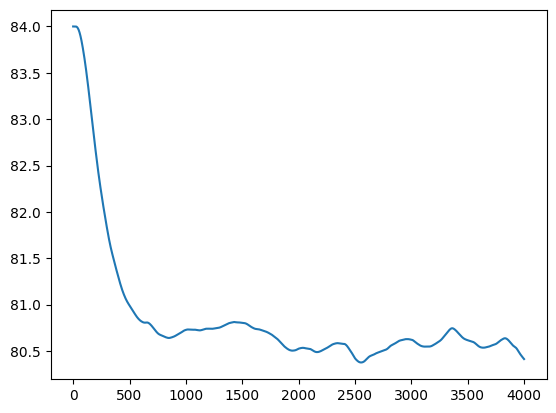

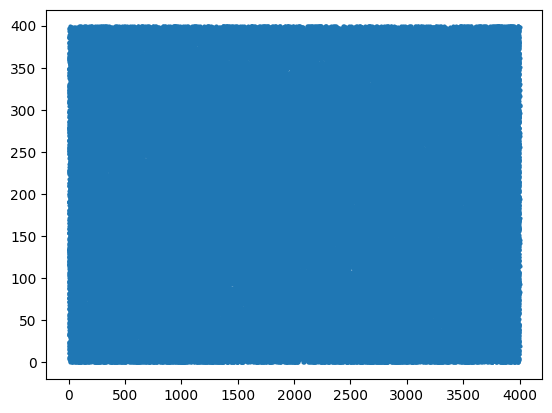

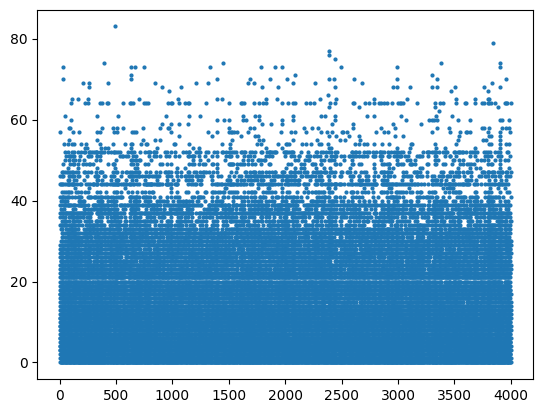

valor: 200


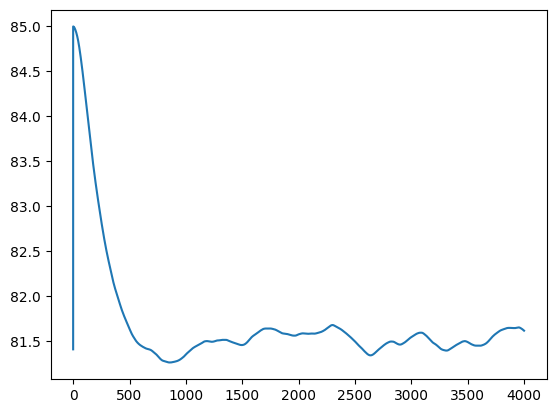

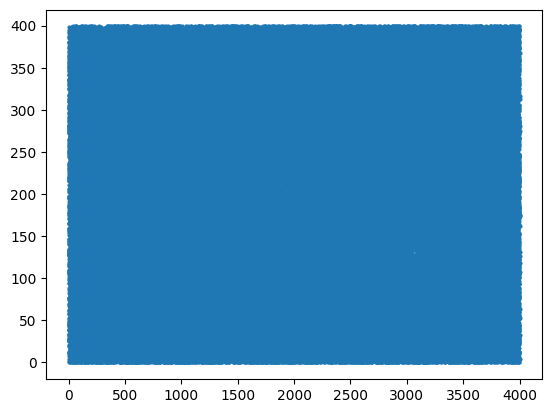

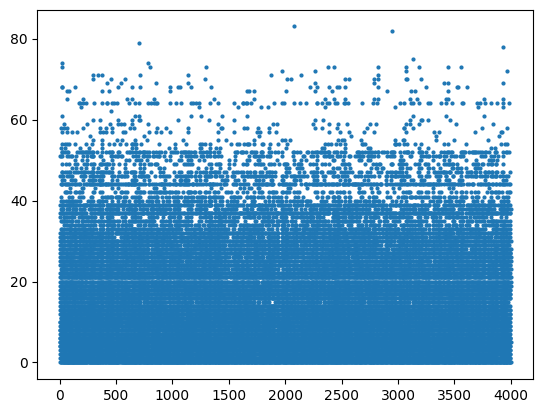

valor: 300


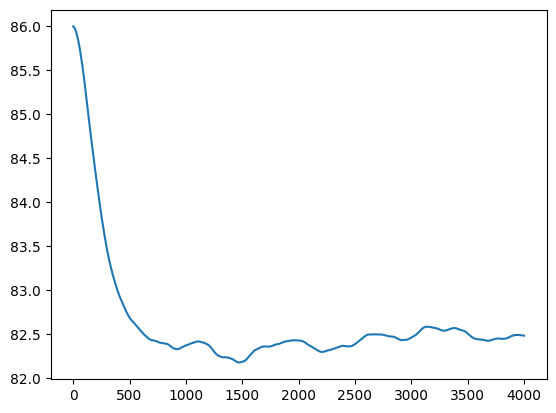

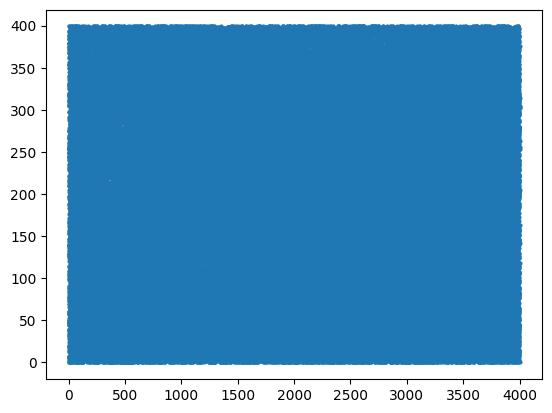

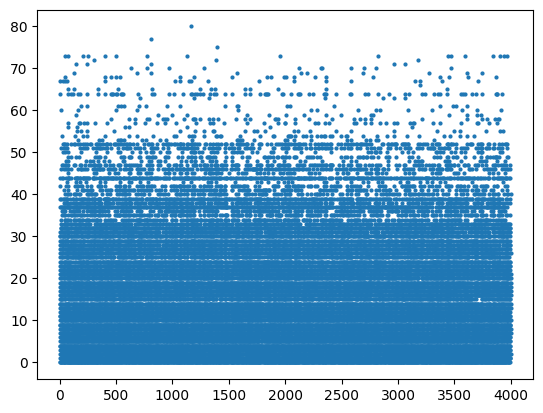

valor: 400


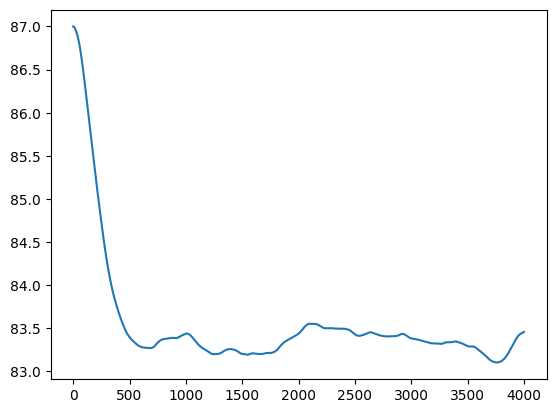

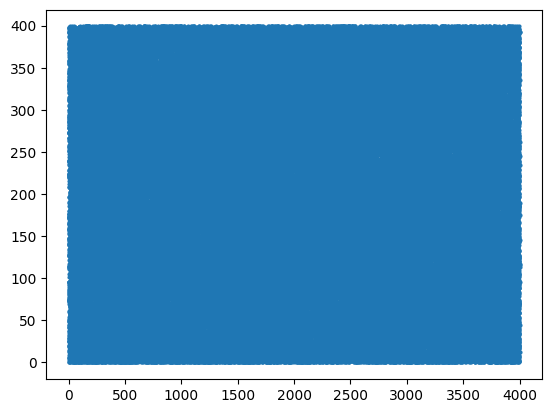

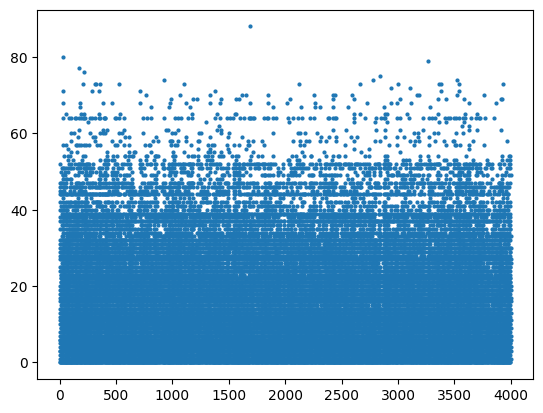

valor: 500


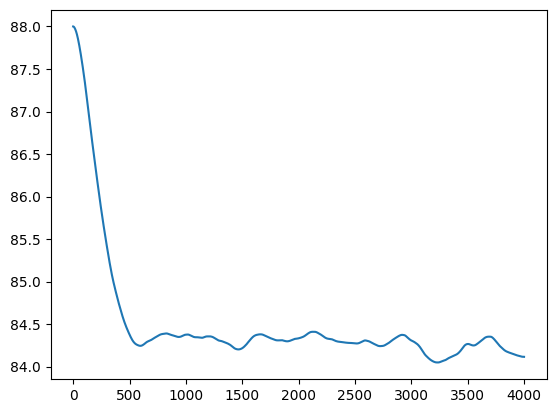

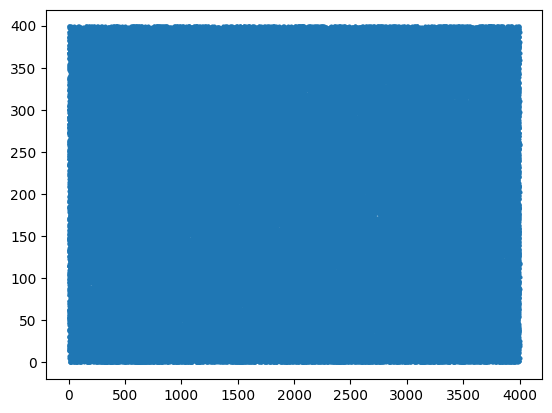

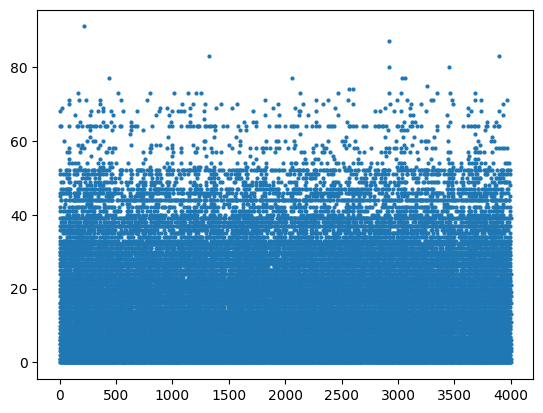

valor: 600


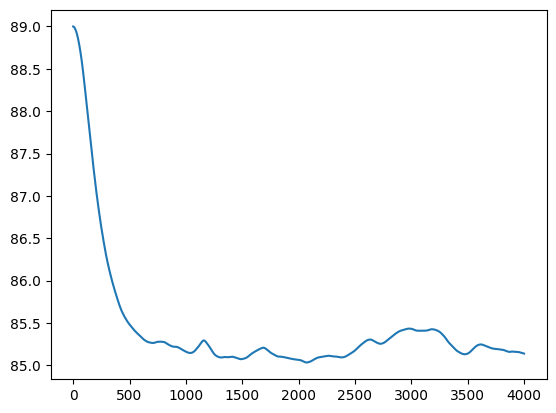

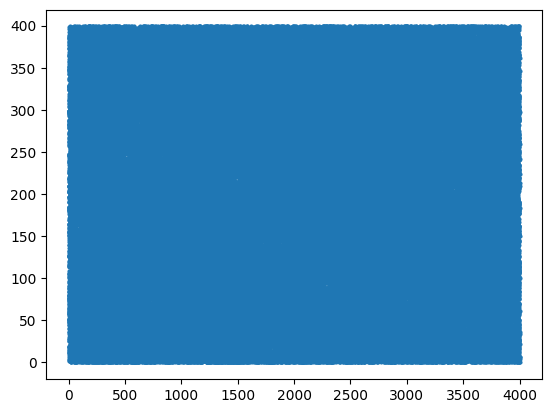

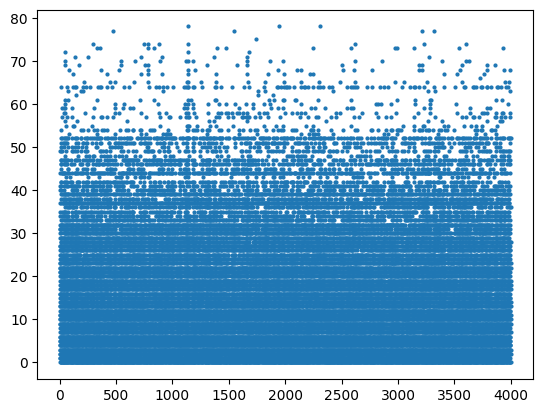

valor: 700


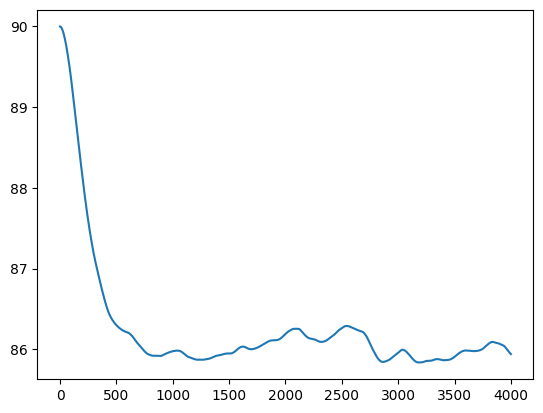

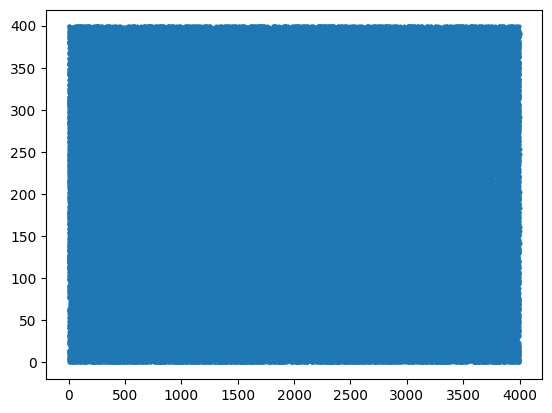

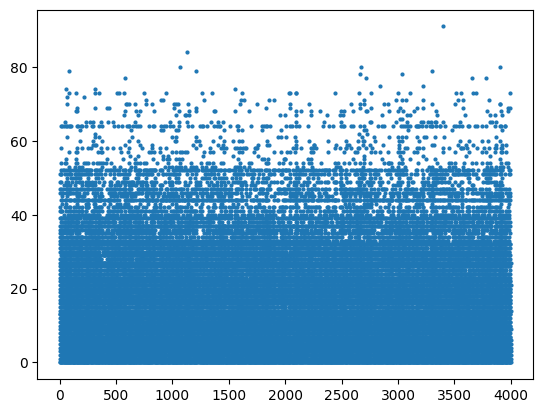

valor: 800


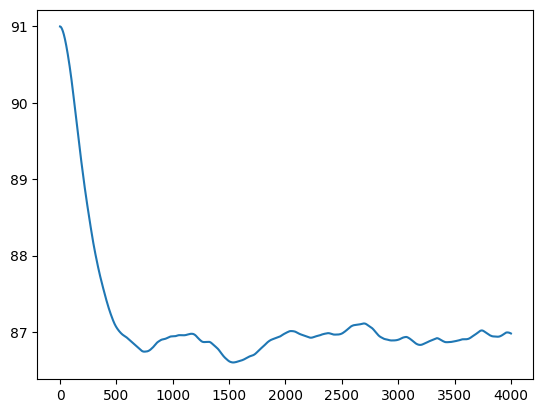

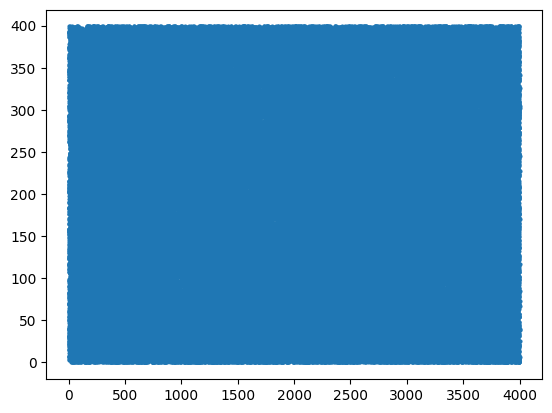

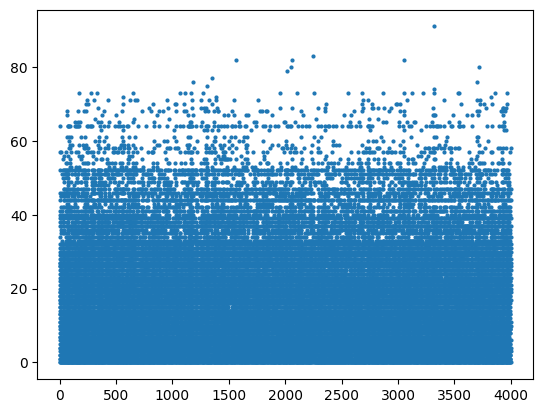

valor: 900


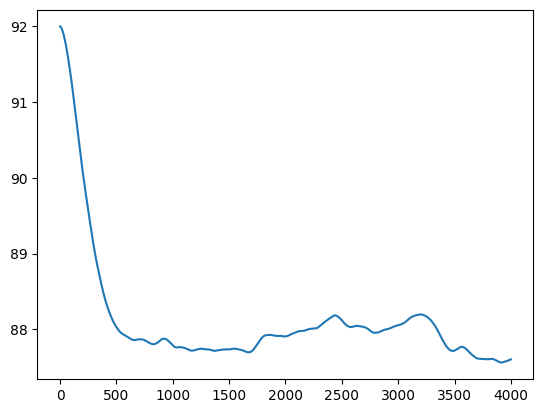

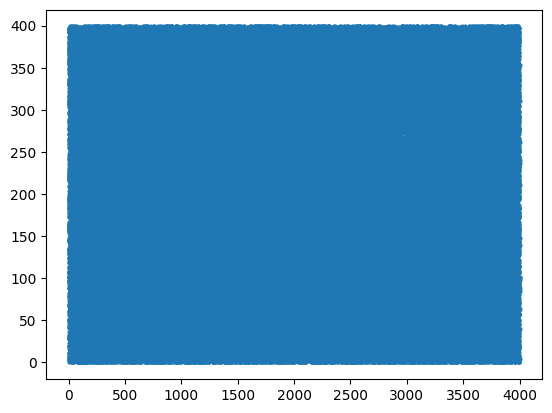

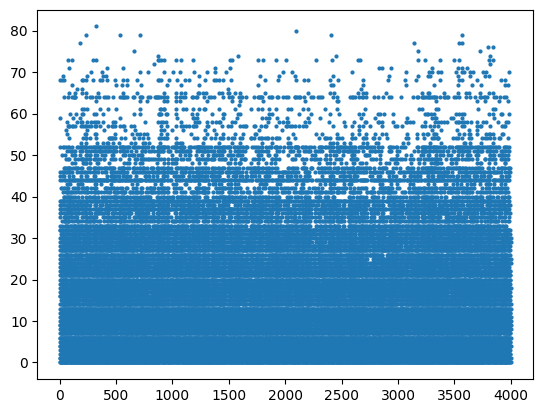

valor: 1000


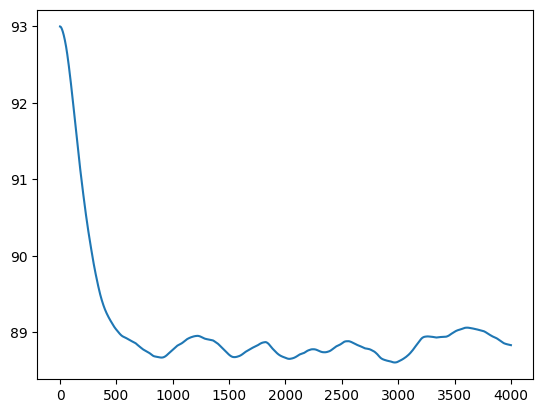

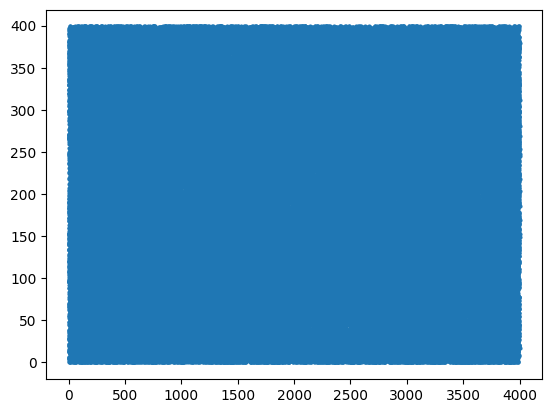

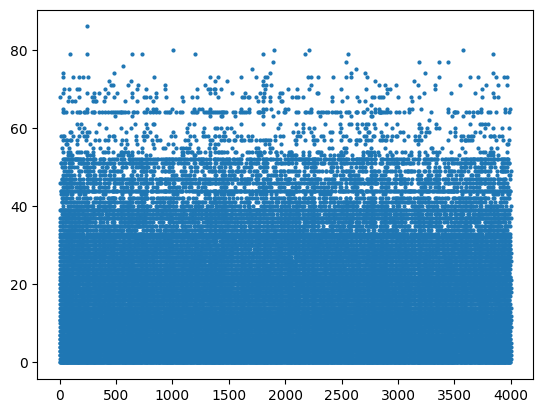

In [5]:

refs = [100, 200,300,400,500,600,700,800,900,1000]  
n= 0
for ref in refs:
    Tf = 4000
    timestep = 0.05
    sim.run(Tf, callbacks=[Classes.SetRate(spike_source, cells, force_objects, ref=ref)])

    #teste força
    força_total = soma_força(force_objects, h, f).as_numpy()
    rate = 83 + ((ref - força_total) * 0.01)
    t = np.arange(0, Tf + timestep, timestep)
    plt.plot(np.arange(0, Tf+timestep, timestep), força_total)
    plt.show()

    df = pd.DataFrame({'time': t, 'força_total': força_total, 'rate': rate})
    filename = f'forca_ref_{ref}.csv'
    df.to_csv(filename, index=False) 

    data_source = spike_source.get_data().segments[n]
    data = cells.get_data().segments[n]

    #teste spike_datasource
    spike_df = pd.DataFrame([{"neuron_id": neuron_id, "spike_time": spike_time}
        for neuron_id, spikes in enumerate(data_source.spiketrains)
        for spike_time in spikes])
    filename = f'spike_data_ref_{ref}.csv'
    spike_df.to_csv(filename, index=False)

    plt.scatter(spike_df["spike_time"], spike_df["neuron_id"], s=4, label=f"ref={ref}")
    plt.show()

    #teste spike_data
    cell_spike_df = pd.DataFrame([{"neuron_id": neuron_id, "spike_time": spike_time}
        for neuron_id, spikes in enumerate(data.spiketrains)
        for spike_time in spikes])

    filename = f'cell_spike_ref_{ref}.csv'
    cell_spike_df.to_csv(filename, index=False)

    plt.scatter(cell_spike_df["spike_time"], cell_spike_df["neuron_id"], s=4,label=f"ref={ref}")
    plt.show()
    sim.reset()
    n = n+1
